# HIPS vs Aethalometer: Smooth/Raw Threshold Analysis

## Purpose
This notebook examines how the aethalometer's smoothing algorithm affects the comparison between **HIPS** (optical absorption) and **aethalometer BC** (optical absorption).

## Why HIPS vs Aethalometer?
- **Both are absorption-based measurements** - this is a "like-to-like" comparison
- FTIR EC vs Aethalometer compares thermal vs optical methods (different techniques)
- At JPL, HIPS vs Aeth showed surprisingly good agreement (R² ~ 0.67) while FTIR EC vs Aeth was poor
- By comparing two absorption methods, we remove the confounding factor of different measurement techniques

## What is Smooth vs Raw?
The aethalometer provides both:
- **Raw BC**: Direct measurement
- **Smoothed BC**: Processed by manufacturer's smoothing algorithm

Large differences between smooth and raw values may indicate:
- Instrument noise or instability
- Rapid concentration changes that the smoothing algorithm struggles with
- Potential data quality issues

## Analysis Approach
1. Calculate % difference between smoothed and raw BC for each day
2. Filter data at different thresholds (1%, 2.5%, 4%, 5%)
3. Compare HIPS vs Aethalometer regression at each threshold
4. Determine if filtering improves correlation

---

## 1. Setup and Imports

In [1]:
# Add scripts folder to path
import sys
sys.path.insert(0, './scripts')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from our modular scripts
from config import (
    SITES, PROCESSED_SITES_DIR, FILTER_DATA_PATH,
    MAC_VALUE, SMOOTH_RAW_THRESHOLDS
)

from data_matching import (
    load_aethalometer_data, load_filter_data,
    get_site_color
)

from plotting import calculate_regression_stats

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Modules loaded successfully!")
print(f"\nSites configured: {list(SITES.keys())}")
print(f"MAC value: {MAC_VALUE} m^2/g")
print(f"Smooth/Raw thresholds to test: {SMOOTH_RAW_THRESHOLDS}%")

Modules loaded successfully!

Sites configured: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']
MAC value: 10 m^2/g
Smooth/Raw thresholds to test: [1, 2.5, 4, 5]%


## 2. Load Data

In [2]:
# Load aethalometer data
aethalometer_data = load_aethalometer_data()

# Load filter data
filter_data = load_filter_data()

Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4
Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08


## 3. Match HIPS with Aethalometer (Including Smooth/Raw Info)

In [3]:
def match_hips_with_smooth_raw(site_name, df_aeth, filter_data, site_code, wavelength='IR'):
    """
    Match HIPS Fabs and aethalometer data, including smooth/raw difference info.
    
    Returns DataFrame with:
    - date
    - aeth_bc_raw: Raw aethalometer BC (ug/m3)
    - aeth_bc_smooth: Smoothed aethalometer BC (ug/m3)
    - hips_fabs: HIPS Fabs / MAC (ug/m3 equivalent)
    - smooth_raw_diff: Absolute difference (ng/m3)
    - smooth_raw_pct: % difference ((smooth - raw) / raw * 100)
    - smooth_raw_abs_pct: Absolute % difference
    """
    raw_col = f'{wavelength} BCc'
    smooth_col = f'{wavelength} BCc smoothed'
    
    # Check if columns exist
    if raw_col not in df_aeth.columns:
        print(f"  {site_name}: {raw_col} not found in aethalometer data")
        return None
    
    has_smooth = smooth_col in df_aeth.columns
    if not has_smooth:
        print(f"  {site_name}: {smooth_col} not found - cannot calculate smooth/raw difference")
        return None
    
    # Get HIPS Fabs data for this site
    site_hips = filter_data[
        (filter_data['Site'] == site_code) &
        (filter_data['Parameter'] == 'HIPS_Fabs')
    ].copy()
    
    if len(site_hips) == 0:
        print(f"  {site_name}: No HIPS data available")
        return None
    
    matched_records = []
    
    for _, filter_row in site_hips.iterrows():
        filter_date = filter_row['SampleDate']
        
        # Find matching aethalometer data (within 1 day tolerance)
        date_match = df_aeth[
            (df_aeth['day_9am'] >= filter_date - pd.Timedelta(days=1)) &
            (df_aeth['day_9am'] <= filter_date + pd.Timedelta(days=1))
        ]
        
        if len(date_match) > 0:
            bc_raw = date_match[raw_col].mean()  # ng/m3
            bc_smooth = date_match[smooth_col].mean()  # ng/m3
            
            if pd.notna(bc_raw) and pd.notna(bc_smooth) and pd.notna(filter_row['Concentration']):
                # HIPS Fabs (Mm^-1) to BC equivalent (ug/m3) using MAC
                hips_fabs = filter_row['Concentration'] / MAC_VALUE
                
                # Calculate differences
                diff_abs = bc_smooth - bc_raw  # ng/m3
                pct_diff = ((bc_smooth - bc_raw) / bc_raw) * 100 if bc_raw != 0 else np.nan
                
                matched_records.append({
                    'date': filter_date,
                    'aeth_bc_raw': bc_raw / 1000,  # Convert to ug/m3
                    'aeth_bc_smooth': bc_smooth / 1000,  # Convert to ug/m3
                    'hips_fabs': hips_fabs,  # Already ug/m3
                    'smooth_raw_diff': diff_abs,  # ng/m3
                    'smooth_raw_pct': pct_diff,
                    'smooth_raw_abs_pct': abs(pct_diff) if pd.notna(pct_diff) else np.nan,
                    'filter_id': filter_row.get('FilterId', 'unknown')
                })
    
    if len(matched_records) == 0:
        print(f"  {site_name}: No matched HIPS-Aethalometer pairs found")
        return None
    
    return pd.DataFrame(matched_records)

print("HIPS smooth/raw matching function defined.")

HIPS smooth/raw matching function defined.


In [4]:
# Match HIPS with aethalometer smooth/raw info for each site
hips_aeth_data = {}

print("Matching HIPS with Aethalometer data (including smooth/raw info)...")
print("="*70)

for site_name in SITES:
    if site_name not in aethalometer_data:
        print(f"{site_name}: No aethalometer data")
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_hips_with_smooth_raw(
        site_name, df_aeth, filter_data, config['code']
    )
    
    if matched is not None and len(matched) >= 3:
        hips_aeth_data[site_name] = matched
        n_with_smooth = matched['smooth_raw_abs_pct'].notna().sum()
        print(f"\n{site_name}:")
        print(f"  Matched pairs: {len(matched)}")
        print(f"  With smooth/raw data: {n_with_smooth}")
        print(f"  Date range: {matched['date'].min().date()} to {matched['date'].max().date()}")
    else:
        print(f"{site_name}: Insufficient matched data")

print(f"\n{'='*70}")
print(f"Total sites with HIPS-Aethalometer data: {len(hips_aeth_data)}")

Matching HIPS with Aethalometer data (including smooth/raw info)...

Beijing:
  Matched pairs: 73
  With smooth/raw data: 73
  Date range: 2023-09-20 to 2024-10-06

Delhi:
  Matched pairs: 25
  With smooth/raw data: 25
  Date range: 2024-03-05 to 2024-05-29

JPL:
  Matched pairs: 68
  With smooth/raw data: 68
  Date range: 2022-07-22 to 2023-11-14

Addis_Ababa:
  Matched pairs: 181
  With smooth/raw data: 181
  Date range: 2022-12-07 to 2024-09-21

Total sites with HIPS-Aethalometer data: 4


## 4. Smooth/Raw Difference Distribution

Before filtering, let's understand the distribution of smooth/raw differences at each site.

SMOOTH/RAW DIFFERENCE DISTRIBUTION

Shows how much the smoothing algorithm changes the BC values.
Positive % = smoothed > raw, Negative % = smoothed < raw


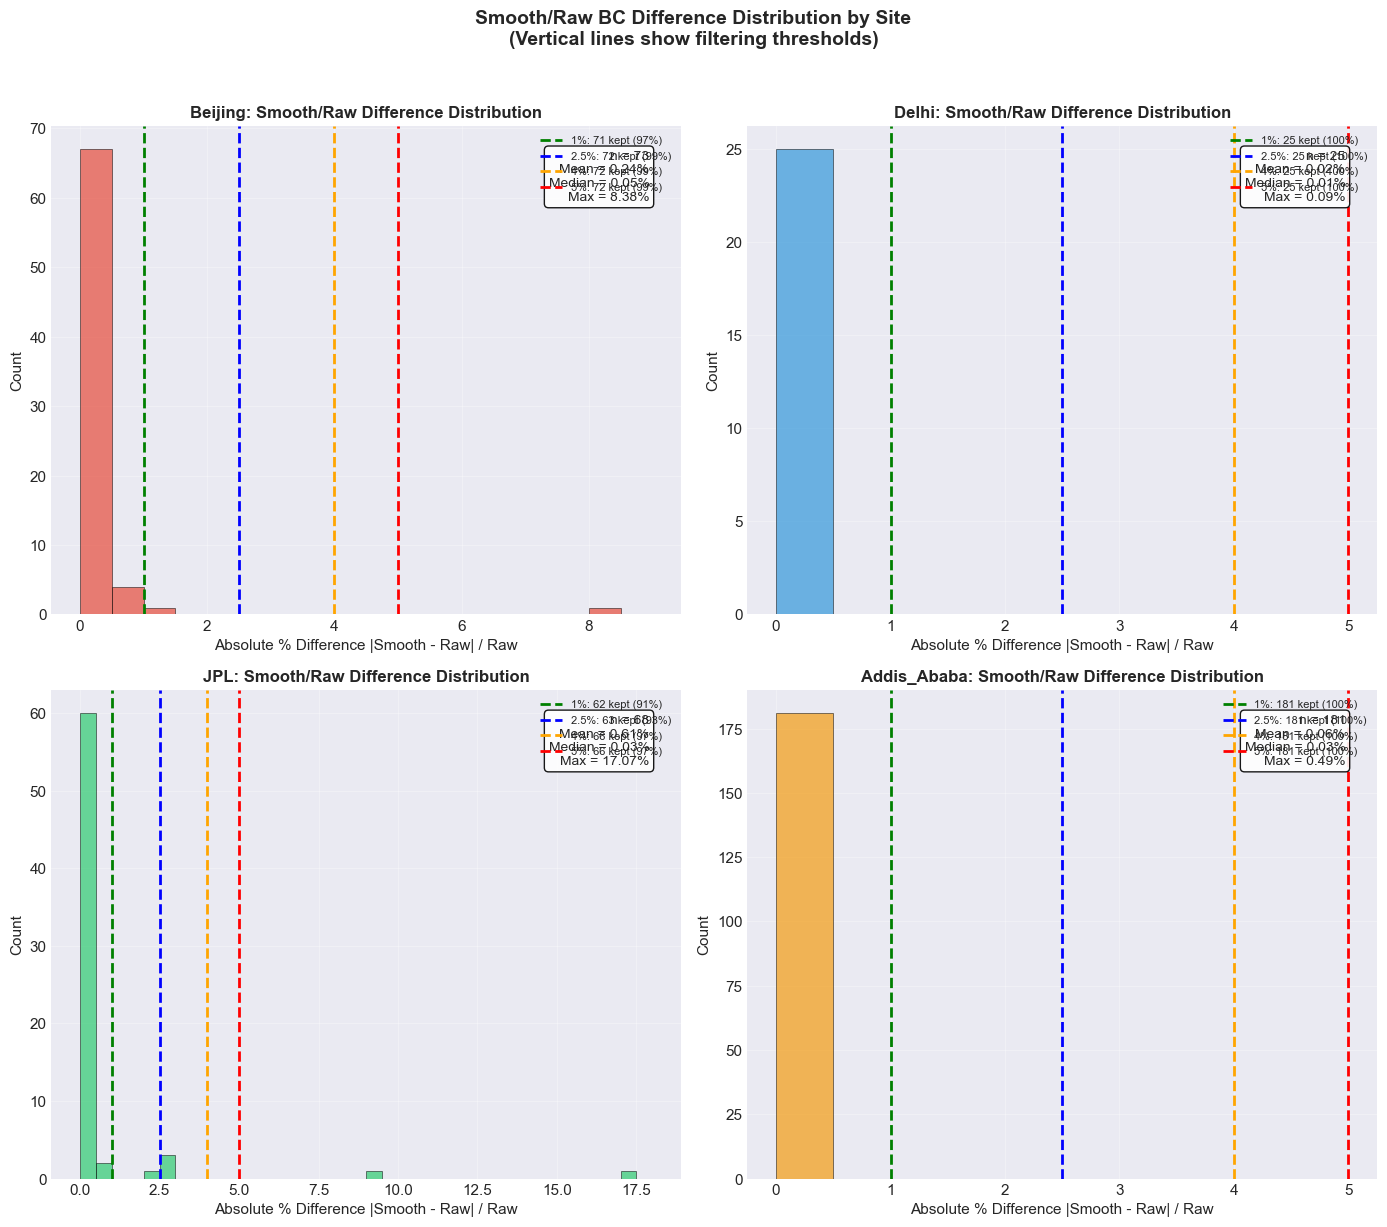


Smooth/Raw Difference Summary:
Site                 n     Mean %   Median %      Max %
-------------------------------------------------------
Beijing             73       0.24       0.05       8.38
Delhi               25       0.02       0.01       0.09
JPL                 68       0.61       0.03      17.07
Addis_Ababa        181       0.06       0.03       0.49


In [5]:
# Visualize smooth/raw % difference distribution for each site
print("="*80)
print("SMOOTH/RAW DIFFERENCE DISTRIBUTION")
print("="*80)
print("\nShows how much the smoothing algorithm changes the BC values.")
print("Positive % = smoothed > raw, Negative % = smoothed < raw")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (site_name, matched_df) in enumerate(hips_aeth_data.items()):
    if idx >= 4:
        break
        
    ax = axes[idx]
    config = SITES[site_name]
    
    # Get smooth/raw % differences
    pct_diff = matched_df['smooth_raw_pct'].dropna()
    abs_pct_diff = matched_df['smooth_raw_abs_pct'].dropna()
    
    if len(abs_pct_diff) == 0:
        ax.text(0.5, 0.5, 'No smooth/raw data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{site_name}', fontsize=12, fontweight='bold')
        continue
    
    # Histogram of absolute % difference
    bins = np.arange(0, min(abs_pct_diff.max() + 1, 20), 0.5)
    ax.hist(abs_pct_diff, bins=bins, color=config['color'], alpha=0.7,
            edgecolor='black', linewidth=0.5)
    
    # Add threshold lines
    threshold_colors = ['green', 'blue', 'orange', 'red']
    for threshold, color in zip(SMOOTH_RAW_THRESHOLDS, threshold_colors):
        n_below = (abs_pct_diff <= threshold).sum()
        pct_below = n_below / len(abs_pct_diff) * 100
        ax.axvline(x=threshold, color=color, linestyle='--', linewidth=2,
                   label=f'{threshold}%: {n_below} kept ({pct_below:.0f}%)')
    
    # Statistics
    stats_text = f"n = {len(abs_pct_diff)}\n"
    stats_text += f"Mean = {abs_pct_diff.mean():.2f}%\n"
    stats_text += f"Median = {abs_pct_diff.median():.2f}%\n"
    stats_text += f"Max = {abs_pct_diff.max():.2f}%"
    
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel('Absolute % Difference |Smooth - Raw| / Raw', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'{site_name}: Smooth/Raw Difference Distribution', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(hips_aeth_data), 4):
    axes[idx].set_visible(False)

plt.suptitle('Smooth/Raw BC Difference Distribution by Site\n(Vertical lines show filtering thresholds)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print("\nSmooth/Raw Difference Summary:")
print(f"{'Site':<15s} {'n':>6s} {'Mean %':>10s} {'Median %':>10s} {'Max %':>10s}")
print("-" * 55)
for site_name, matched_df in hips_aeth_data.items():
    abs_pct = matched_df['smooth_raw_abs_pct'].dropna()
    if len(abs_pct) > 0:
        print(f"{site_name:<15s} {len(abs_pct):>6d} {abs_pct.mean():>10.2f} "
              f"{abs_pct.median():>10.2f} {abs_pct.max():>10.2f}")

## 5. Baseline: HIPS vs Aethalometer (All Data)

First, let's see the baseline correlation without any smooth/raw filtering.

BASELINE: HIPS vs Aethalometer (No Smooth/Raw Filtering)


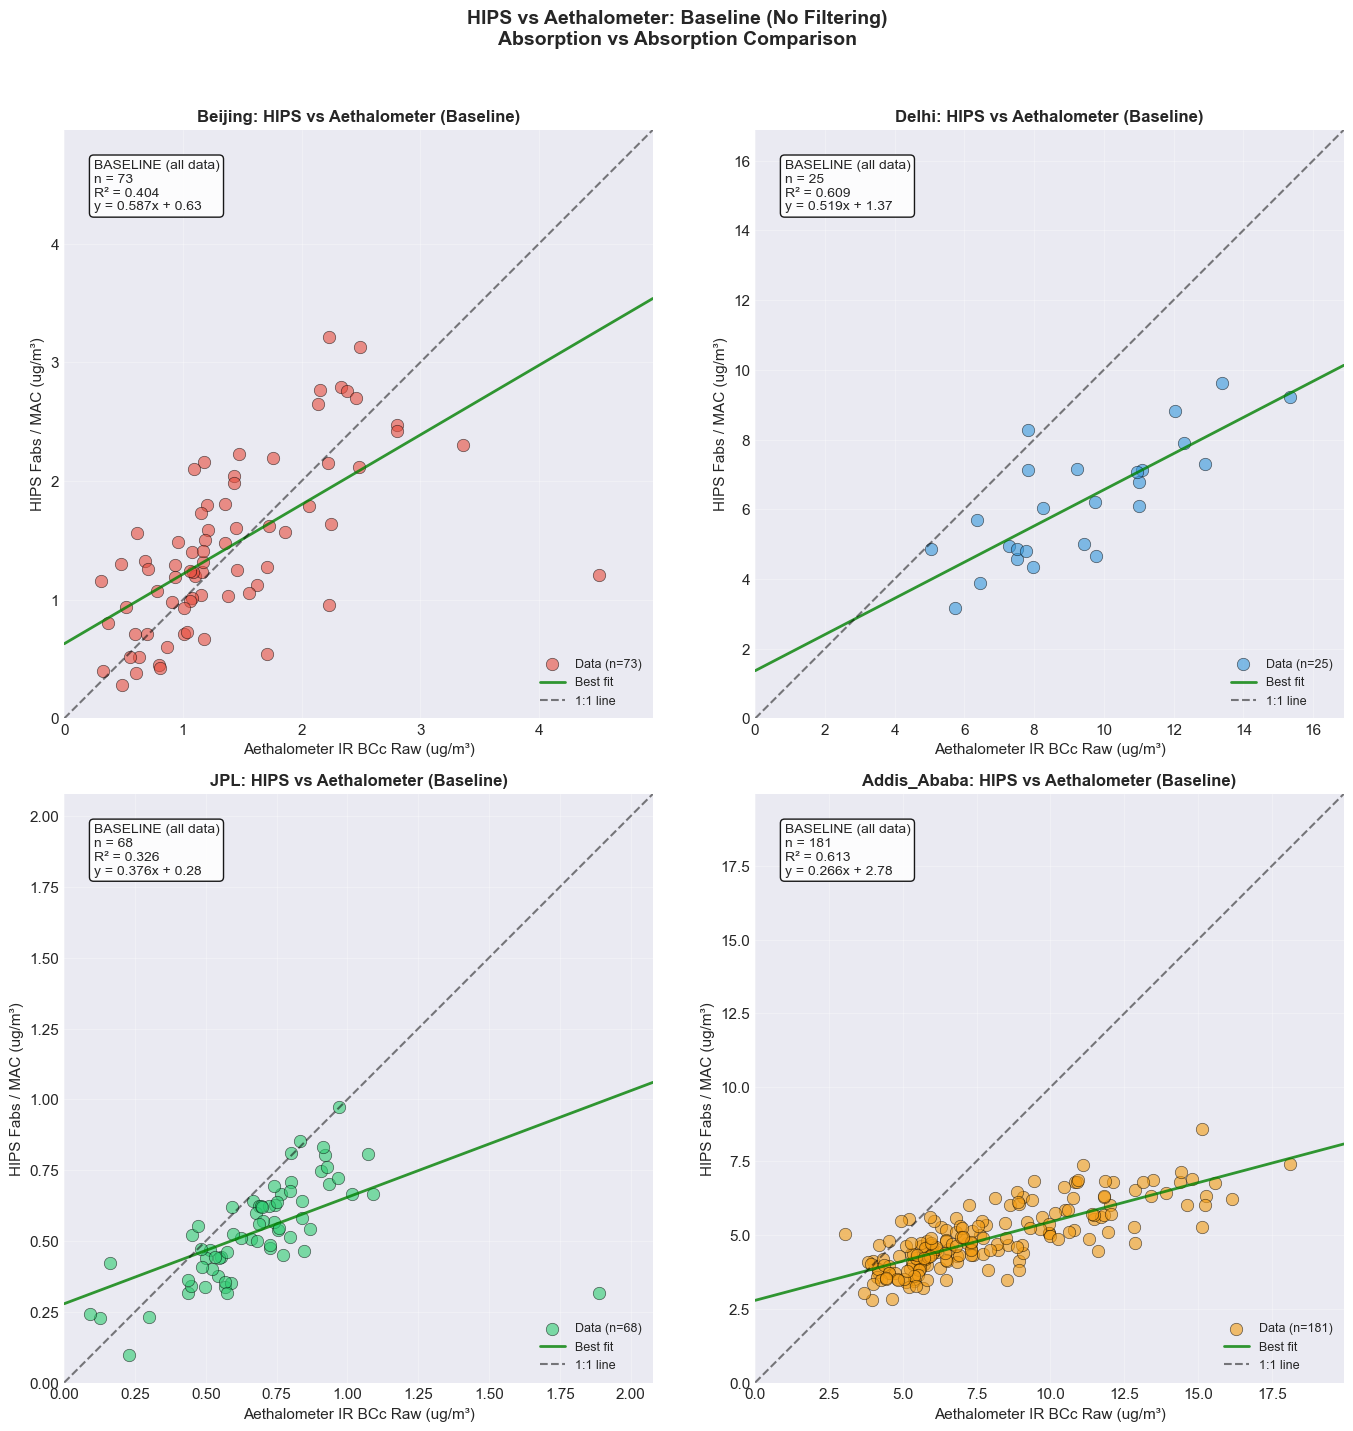


Baseline Statistics (No Filtering):
Site                 n         R²      Slope    Intercept
-------------------------------------------------------
Beijing             73      0.404      0.587         0.63
Delhi               25      0.609      0.519         1.37
JPL                 68      0.326      0.376         0.28
Addis_Ababa        181      0.613      0.266         2.78


In [6]:
# Baseline cross-plots: HIPS vs Aethalometer (no filtering)
print("="*80)
print("BASELINE: HIPS vs Aethalometer (No Smooth/Raw Filtering)")
print("="*80)

baseline_stats = {}

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, (site_name, matched_df) in enumerate(hips_aeth_data.items()):
    if idx >= 4:
        break
    
    ax = axes[idx]
    config = SITES[site_name]
    
    # Use RAW aethalometer BC for comparison
    x_data = matched_df['aeth_bc_raw'].values
    y_data = matched_df['hips_fabs'].values
    
    # Valid data
    valid_mask = (~np.isnan(x_data)) & (~np.isnan(y_data))
    x_valid = x_data[valid_mask]
    y_valid = y_data[valid_mask]
    
    if len(x_valid) < 3:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center',
                transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{site_name}', fontsize=12, fontweight='bold')
        continue
    
    # Plot
    ax.scatter(x_valid, y_valid, color=config['color'], alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5, label=f'Data (n={len(x_valid)})')
    
    # Calculate regression
    stats = calculate_regression_stats(x_valid, y_valid)
    baseline_stats[site_name] = stats
    
    if stats:
        # Axis limits
        max_val = max(x_valid.max(), y_valid.max()) * 1.1
        
        # Regression line
        x_line = np.array([0, max_val])
        y_line = stats['slope'] * x_line + stats['intercept']
        ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
        
        # 1:1 line
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        
        # Stats text
        sign = '+' if stats['intercept'] >= 0 else '-'
        eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
        stats_text = f"BASELINE (all data)\nn = {stats['n']}\nR² = {stats['r_squared']:.3f}\n{eq}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel('Aethalometer IR BCc Raw (ug/m³)', fontsize=11)
    ax.set_ylabel('HIPS Fabs / MAC (ug/m³)', fontsize=11)
    ax.set_title(f'{site_name}: HIPS vs Aethalometer (Baseline)', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

for idx in range(len(hips_aeth_data), 4):
    axes[idx].set_visible(False)

plt.suptitle('HIPS vs Aethalometer: Baseline (No Filtering)\nAbsorption vs Absorption Comparison',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print baseline summary
print("\nBaseline Statistics (No Filtering):")
print(f"{'Site':<15s} {'n':>6s} {'R²':>10s} {'Slope':>10s} {'Intercept':>12s}")
print("-" * 55)
for site_name, stats in baseline_stats.items():
    if stats:
        print(f"{site_name:<15s} {stats['n']:>6d} {stats['r_squared']:>10.3f} "
              f"{stats['slope']:>10.3f} {stats['intercept']:>12.2f}")

## 6. Threshold Analysis: Impact of Smooth/Raw Filtering

Now let's see how filtering by smooth/raw difference affects the correlation.

THRESHOLD ANALYSIS: HIPS vs Aethalometer

Filtering out points where |smooth - raw| / raw > threshold

Beijing: Threshold Analysis


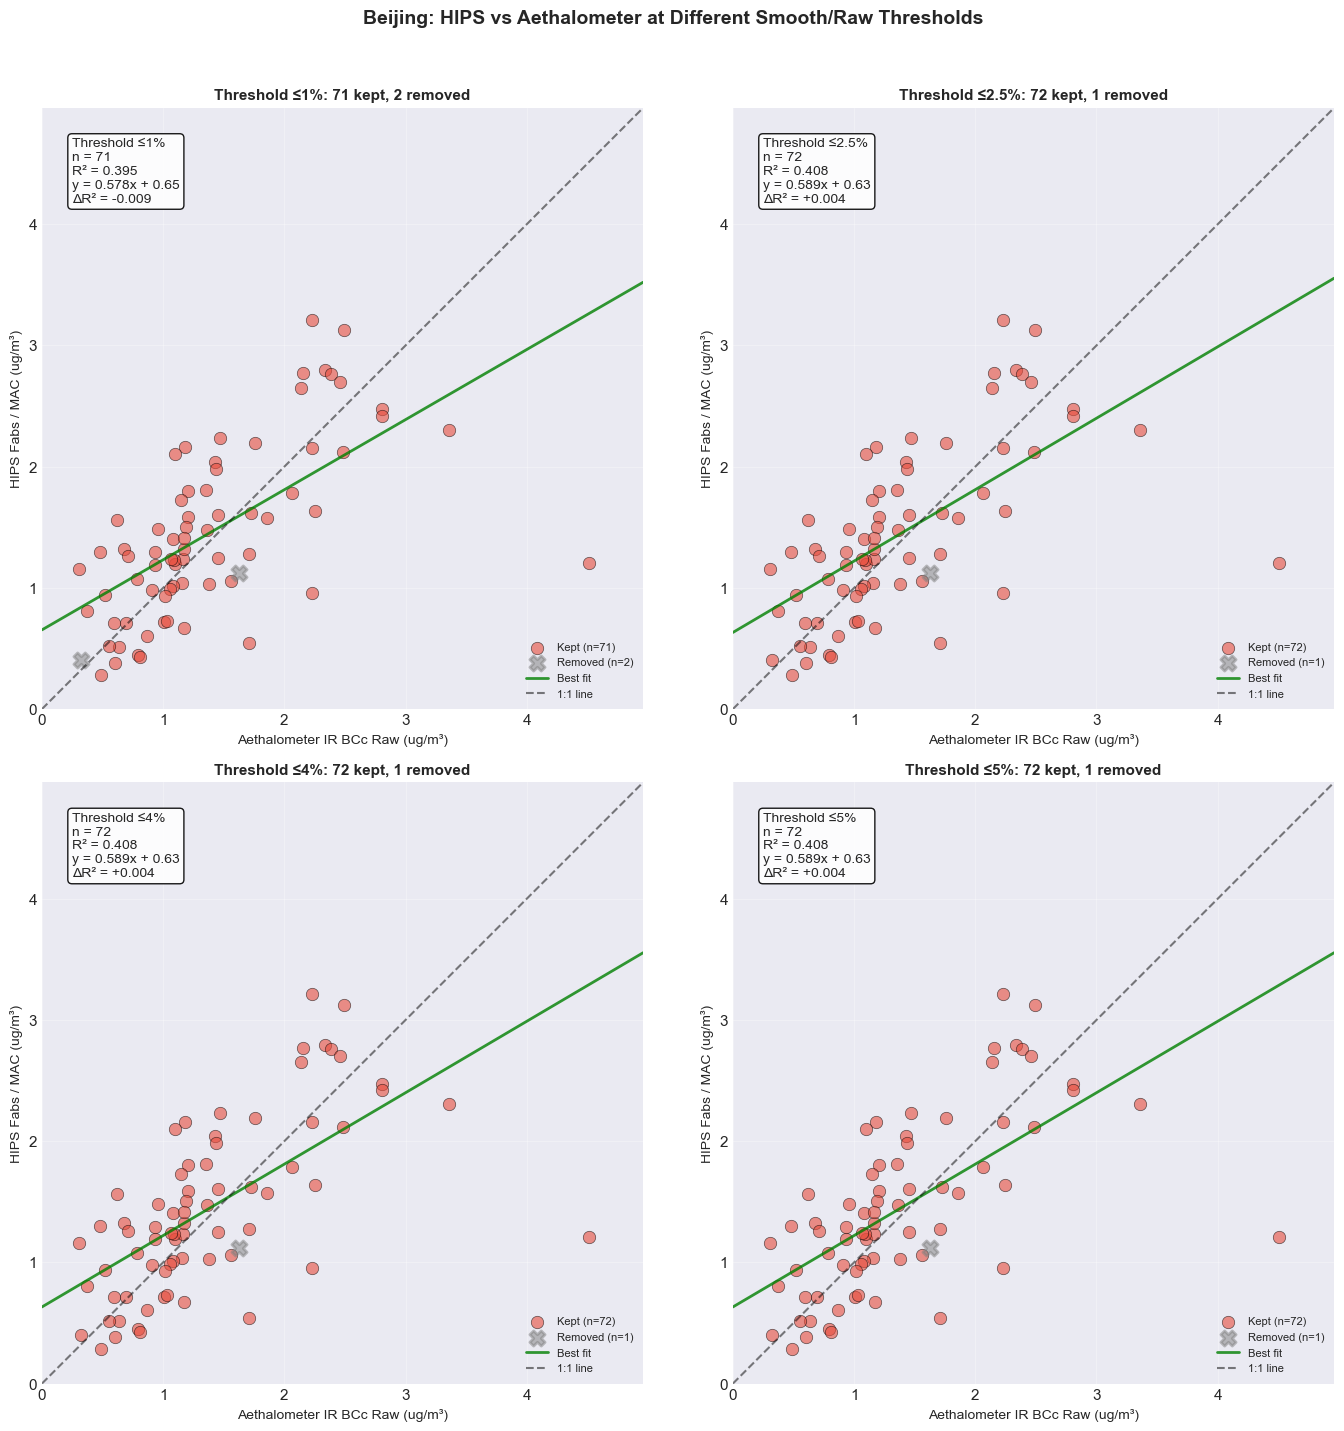


Beijing Results:
Threshold         n         R²      Slope        ΔR²
--------------------------------------------------
Baseline         73      0.404      0.587         --
≤1%              71      0.395      0.578     -0.009
≤2.5%            72      0.408      0.589     +0.004
≤4%              72      0.408      0.589     +0.004
≤5%              72      0.408      0.589     +0.004

Delhi: Threshold Analysis


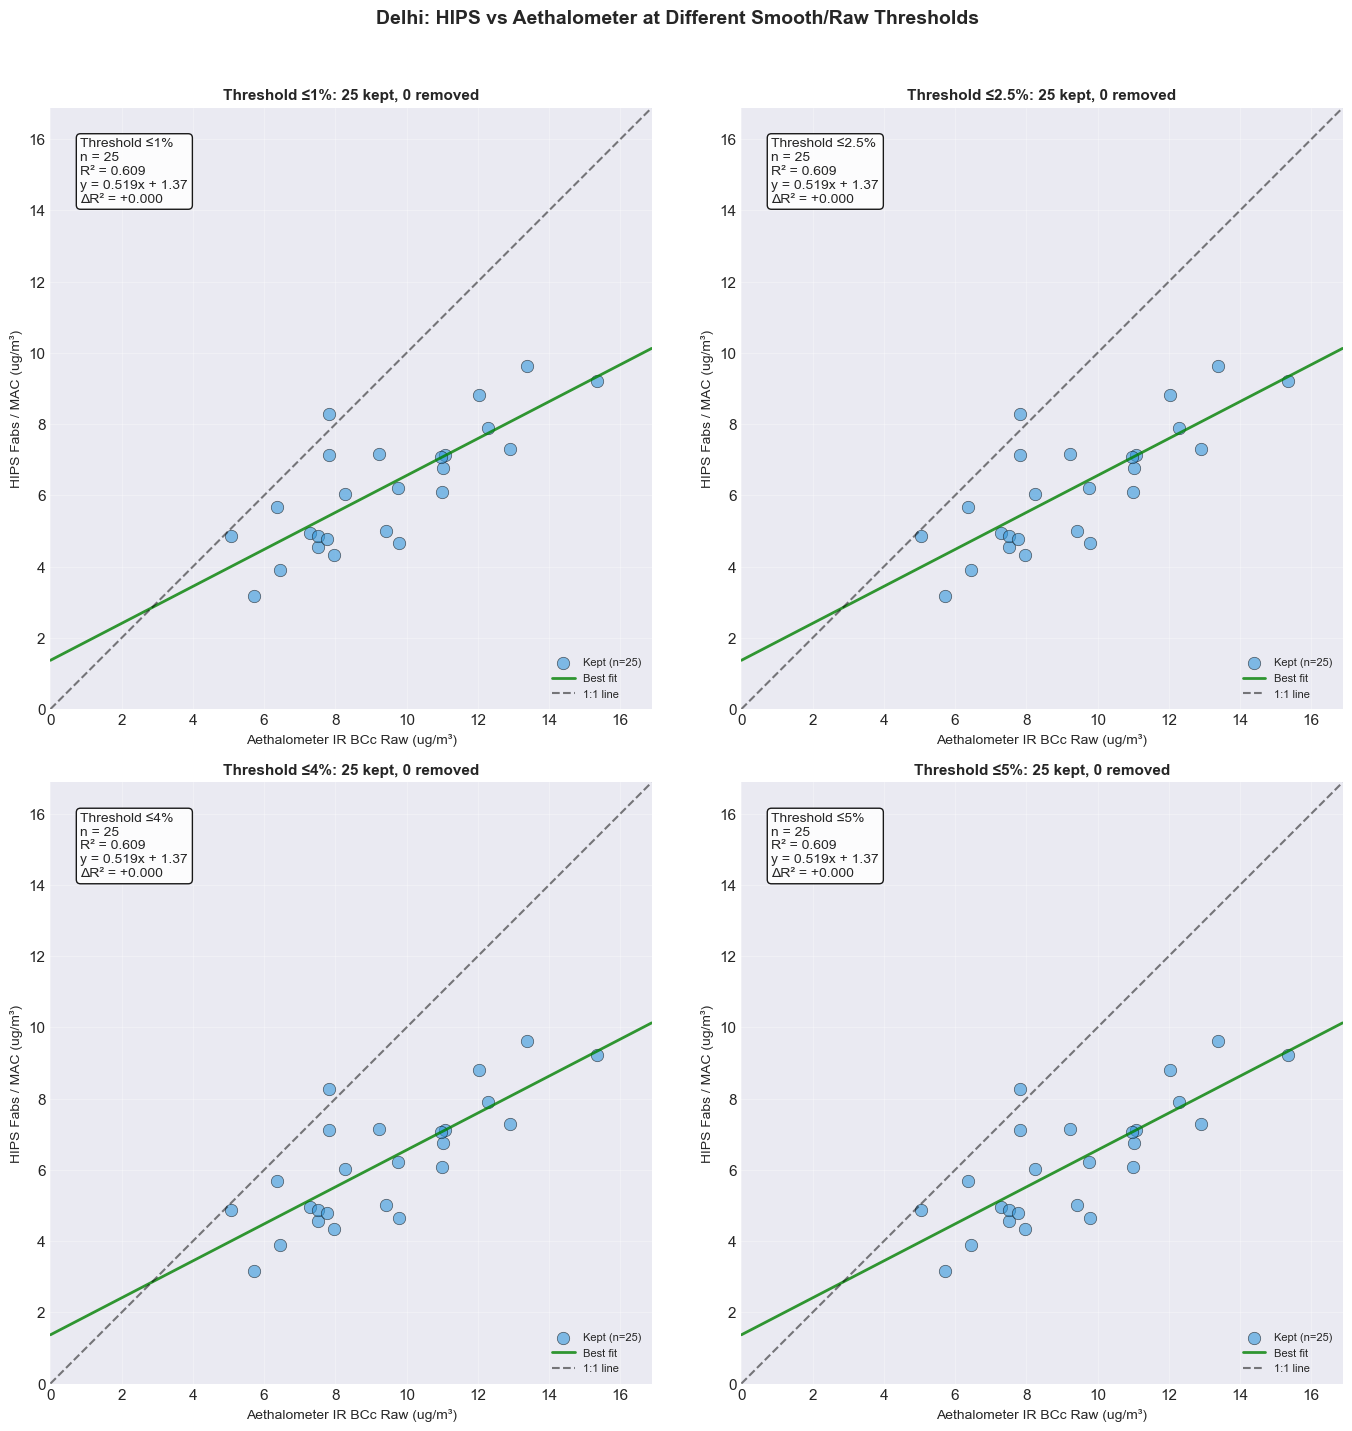


Delhi Results:
Threshold         n         R²      Slope        ΔR²
--------------------------------------------------
Baseline         25      0.609      0.519         --
≤1%              25      0.609      0.519     +0.000
≤2.5%            25      0.609      0.519     +0.000
≤4%              25      0.609      0.519     +0.000
≤5%              25      0.609      0.519     +0.000

JPL: Threshold Analysis


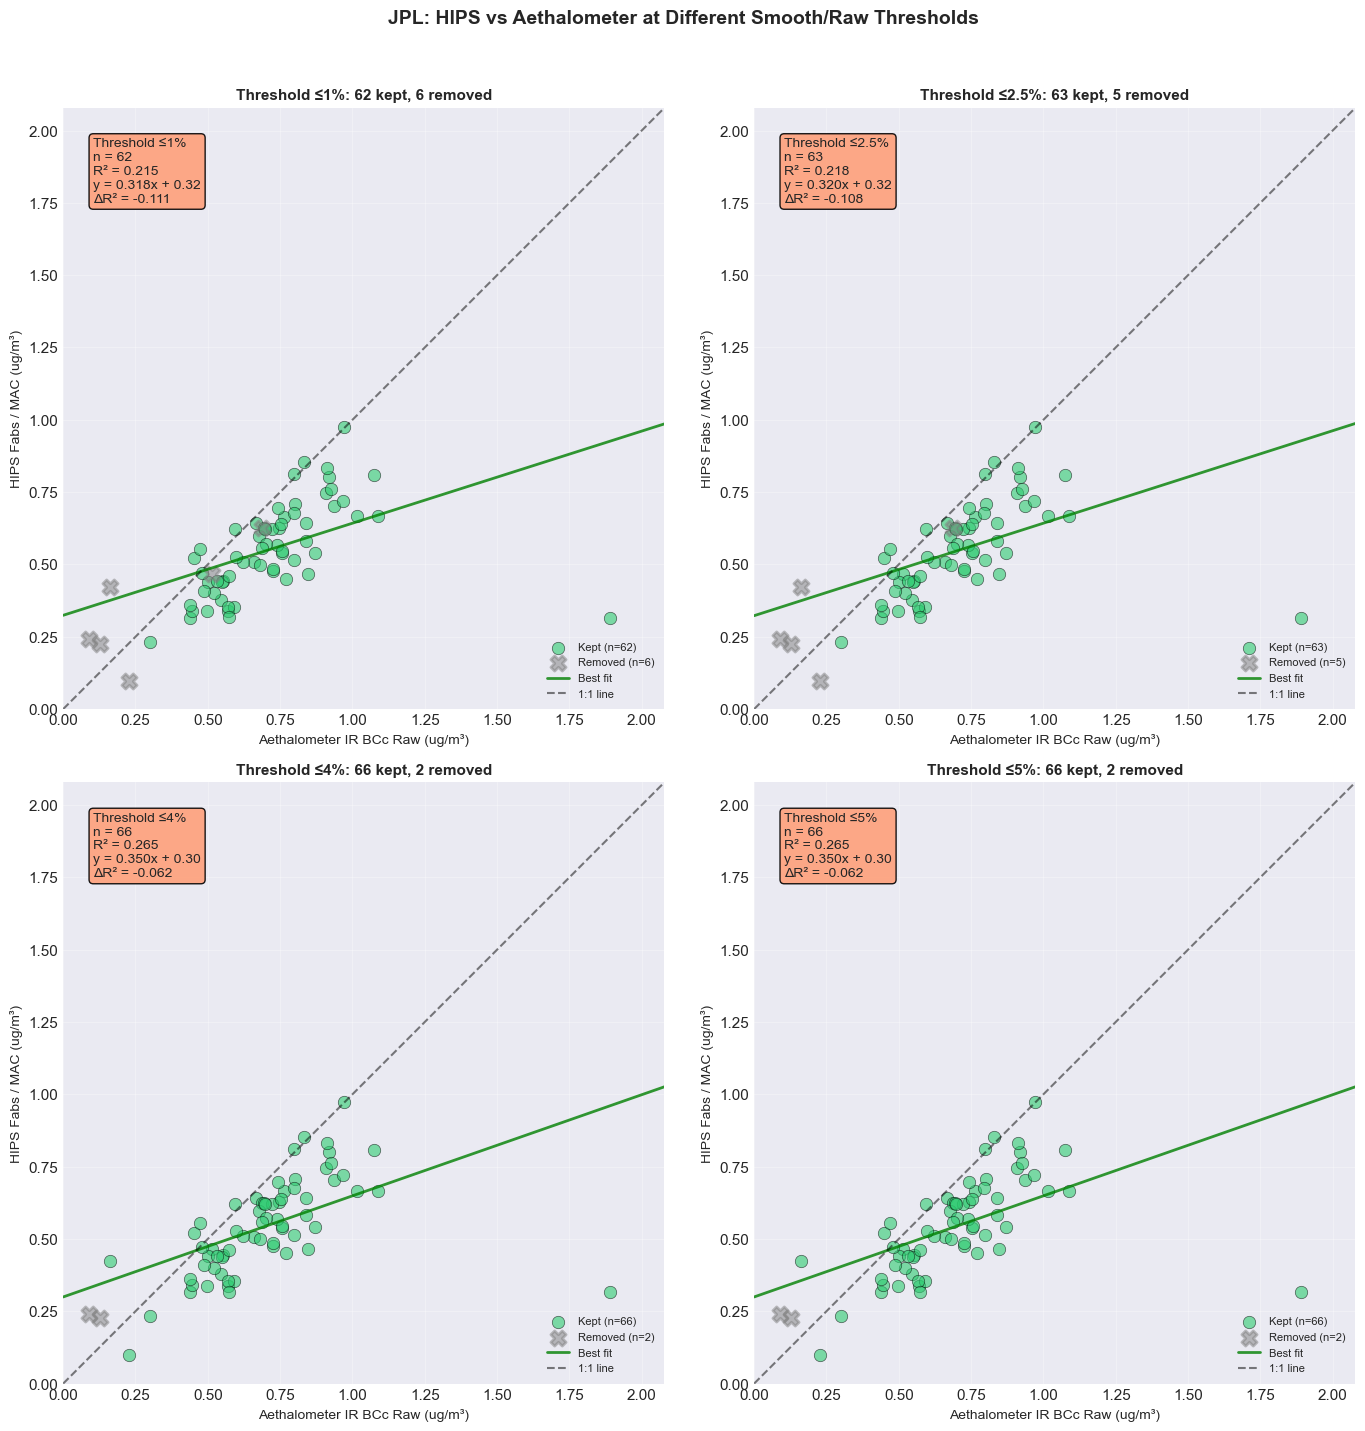


JPL Results:
Threshold         n         R²      Slope        ΔR²
--------------------------------------------------
Baseline         68      0.326      0.376         --
≤1%              62      0.215      0.318     -0.111
≤2.5%            63      0.218      0.320     -0.108
≤4%              66      0.265      0.350     -0.062
≤5%              66      0.265      0.350     -0.062

Addis_Ababa: Threshold Analysis


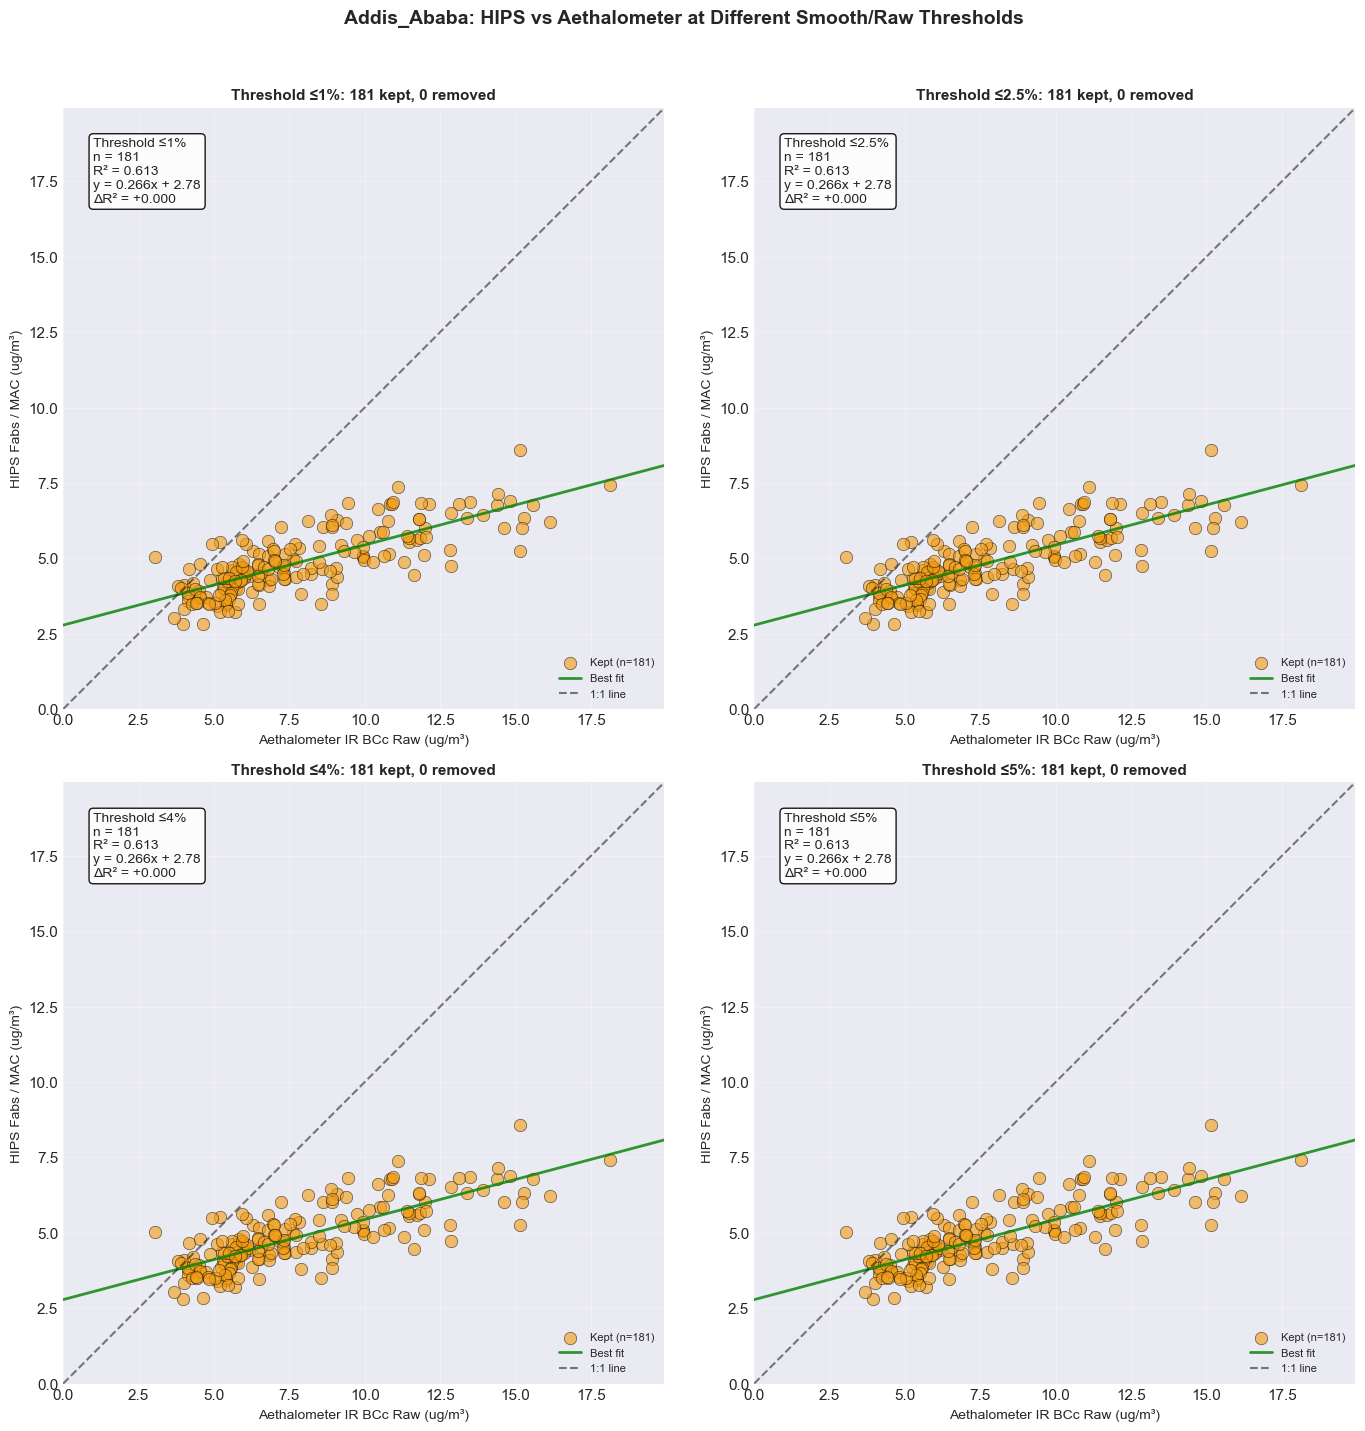


Addis_Ababa Results:
Threshold         n         R²      Slope        ΔR²
--------------------------------------------------
Baseline        181      0.613      0.266         --
≤1%             181      0.613      0.266     +0.000
≤2.5%           181      0.613      0.266     +0.000
≤4%             181      0.613      0.266     +0.000
≤5%             181      0.613      0.266     +0.000


In [7]:
# Threshold analysis for each site
print("="*80)
print("THRESHOLD ANALYSIS: HIPS vs Aethalometer")
print("="*80)
print("\nFiltering out points where |smooth - raw| / raw > threshold")

threshold_results = {}

for site_name, matched_df in hips_aeth_data.items():
    config = SITES[site_name]
    
    print(f"\n{'='*60}")
    print(f"{site_name}: Threshold Analysis")
    print(f"{'='*60}")
    
    # Calculate axis limits (same for all plots)
    x_all = matched_df['aeth_bc_raw'].dropna().values
    y_all = matched_df['hips_fabs'].dropna().values
    all_vals = np.concatenate([x_all, y_all])
    max_val = all_vals.max() * 1.1 if len(all_vals) > 0 else 10
    
    site_results = {'baseline': baseline_stats.get(site_name)}
    
    # Create figure with subplots for each threshold
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for idx, threshold in enumerate(SMOOTH_RAW_THRESHOLDS):
        ax = axes[idx]
        
        # Filter data
        below_threshold = matched_df[matched_df['smooth_raw_abs_pct'] <= threshold].copy()
        above_threshold = matched_df[matched_df['smooth_raw_abs_pct'] > threshold].copy()
        
        n_kept = len(below_threshold)
        n_removed = len(above_threshold)
        
        if n_kept < 3:
            ax.text(0.5, 0.5, f'Insufficient data at {threshold}% threshold\n(n={n_kept})',
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'Threshold ≤{threshold}%', fontsize=12, fontweight='bold')
            site_results[threshold] = None
            continue
        
        # Get data
        x_kept = below_threshold['aeth_bc_raw'].values
        y_kept = below_threshold['hips_fabs'].values
        x_removed = above_threshold['aeth_bc_raw'].values
        y_removed = above_threshold['hips_fabs'].values
        
        # Plot kept points
        ax.scatter(x_kept, y_kept, color=config['color'], alpha=0.6, s=80,
                   edgecolors='black', linewidth=0.5, label=f'Kept (n={n_kept})')
        
        # Plot removed points as gray X
        if n_removed > 0:
            ax.scatter(x_removed, y_removed, color='gray', alpha=0.5, s=120,
                       marker='X', linewidths=2, label=f'Removed (n={n_removed})')
        
        # Calculate regression on kept points
        stats = calculate_regression_stats(x_kept, y_kept)
        site_results[threshold] = stats
        
        if stats:
            # Regression line
            x_line = np.array([0, max_val])
            y_line = stats['slope'] * x_line + stats['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
            
            # Stats text with comparison to baseline
            sign = '+' if stats['intercept'] >= 0 else '-'
            eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
            
            baseline = site_results['baseline']
            if baseline:
                r2_change = stats['r_squared'] - baseline['r_squared']
                change_str = f"\nΔR² = {r2_change:+.3f}"
            else:
                change_str = ""
            
            stats_text = f"Threshold ≤{threshold}%\nn = {stats['n']}\nR² = {stats['r_squared']:.3f}\n{eq}{change_str}"
            
            # Color based on improvement
            if baseline and r2_change > 0.01:
                box_color = 'lightgreen'
            elif baseline and r2_change < -0.01:
                box_color = 'lightsalmon'
            else:
                box_color = 'white'
            
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.9))
        
        # Set axes
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlabel('Aethalometer IR BCc Raw (ug/m³)', fontsize=10)
        ax.set_ylabel('HIPS Fabs / MAC (ug/m³)', fontsize=10)
        ax.set_title(f'Threshold ≤{threshold}%: {n_kept} kept, {n_removed} removed',
                     fontsize=11, fontweight='bold')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{site_name}: HIPS vs Aethalometer at Different Smooth/Raw Thresholds',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    threshold_results[site_name] = site_results
    
    # Print results table
    print(f"\n{site_name} Results:")
    print(f"{'Threshold':<12s} {'n':>6s} {'R²':>10s} {'Slope':>10s} {'ΔR²':>10s}")
    print("-" * 50)
    
    baseline = site_results['baseline']
    if baseline:
        print(f"{'Baseline':<12s} {baseline['n']:>6d} {baseline['r_squared']:>10.3f} "
              f"{baseline['slope']:>10.3f} {'--':>10s}")
    
    for threshold in SMOOTH_RAW_THRESHOLDS:
        stats = site_results.get(threshold)
        if stats:
            r2_change = stats['r_squared'] - baseline['r_squared'] if baseline else 0
            print(f"≤{threshold}%{'':>{10-len(str(threshold))}} {stats['n']:>6d} "
                  f"{stats['r_squared']:>10.3f} {stats['slope']:>10.3f} {r2_change:>+10.3f}")
        else:
            print(f"≤{threshold}%{'':>{10-len(str(threshold))}} {'--':>6s} {'--':>10s} {'--':>10s} {'--':>10s}")

## 7. Summary: R² vs Threshold

Visualize how R² changes with different thresholds across all sites.

R² vs SMOOTH/RAW THRESHOLD


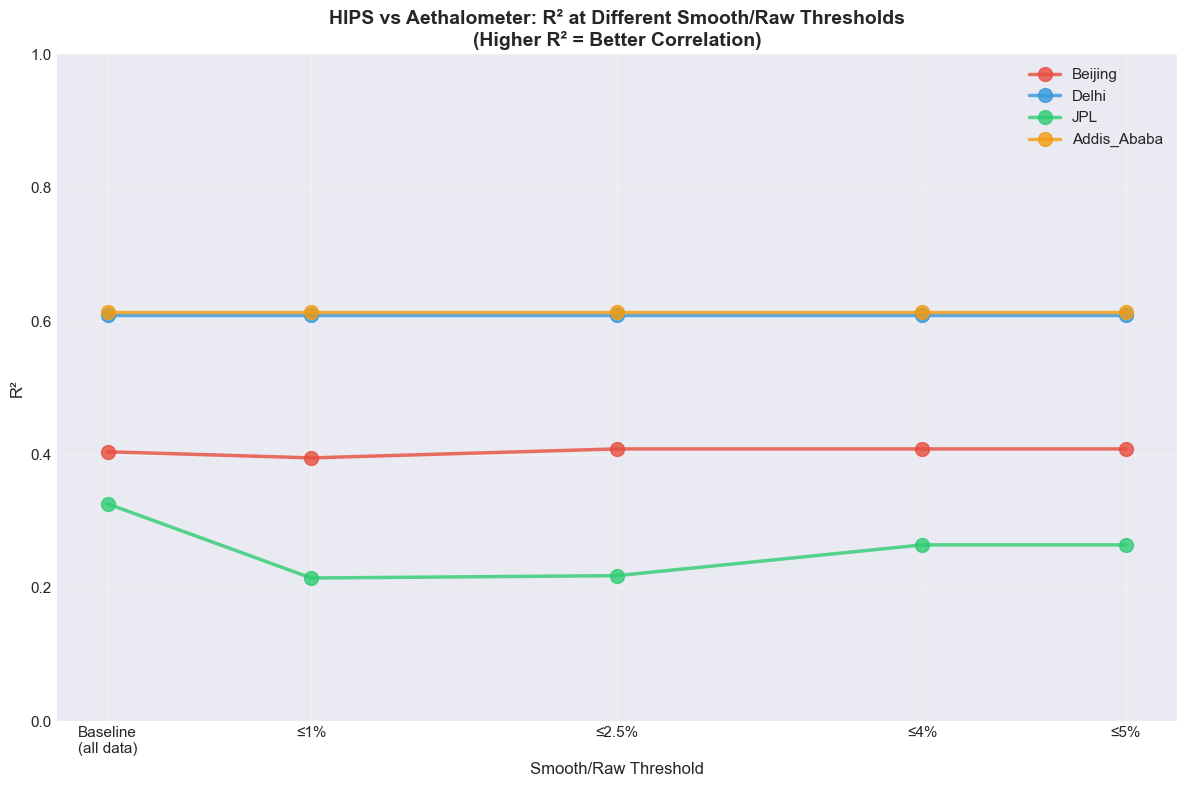

In [8]:
# Plot R² vs Threshold for all sites
print("="*80)
print("R² vs SMOOTH/RAW THRESHOLD")
print("="*80)

fig, ax = plt.subplots(figsize=(12, 8))

x_positions = [0] + SMOOTH_RAW_THRESHOLDS  # 0 = baseline

for site_name, results in threshold_results.items():
    config = SITES[site_name]
    
    r2_values = []
    x_vals = []
    
    # Baseline (x=0)
    if results['baseline']:
        r2_values.append(results['baseline']['r_squared'])
        x_vals.append(0)
    
    # Each threshold
    for threshold in SMOOTH_RAW_THRESHOLDS:
        stats = results.get(threshold)
        if stats:
            r2_values.append(stats['r_squared'])
            x_vals.append(threshold)
    
    if len(r2_values) > 0:
        ax.plot(x_vals, r2_values, 'o-', color=config['color'], linewidth=2.5,
                markersize=10, label=site_name, alpha=0.8)

# Format x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(['Baseline\n(all data)'] + [f'≤{t}%' for t in SMOOTH_RAW_THRESHOLDS])

ax.set_xlabel('Smooth/Raw Threshold', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('HIPS vs Aethalometer: R² at Different Smooth/Raw Thresholds\n(Higher R² = Better Correlation)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

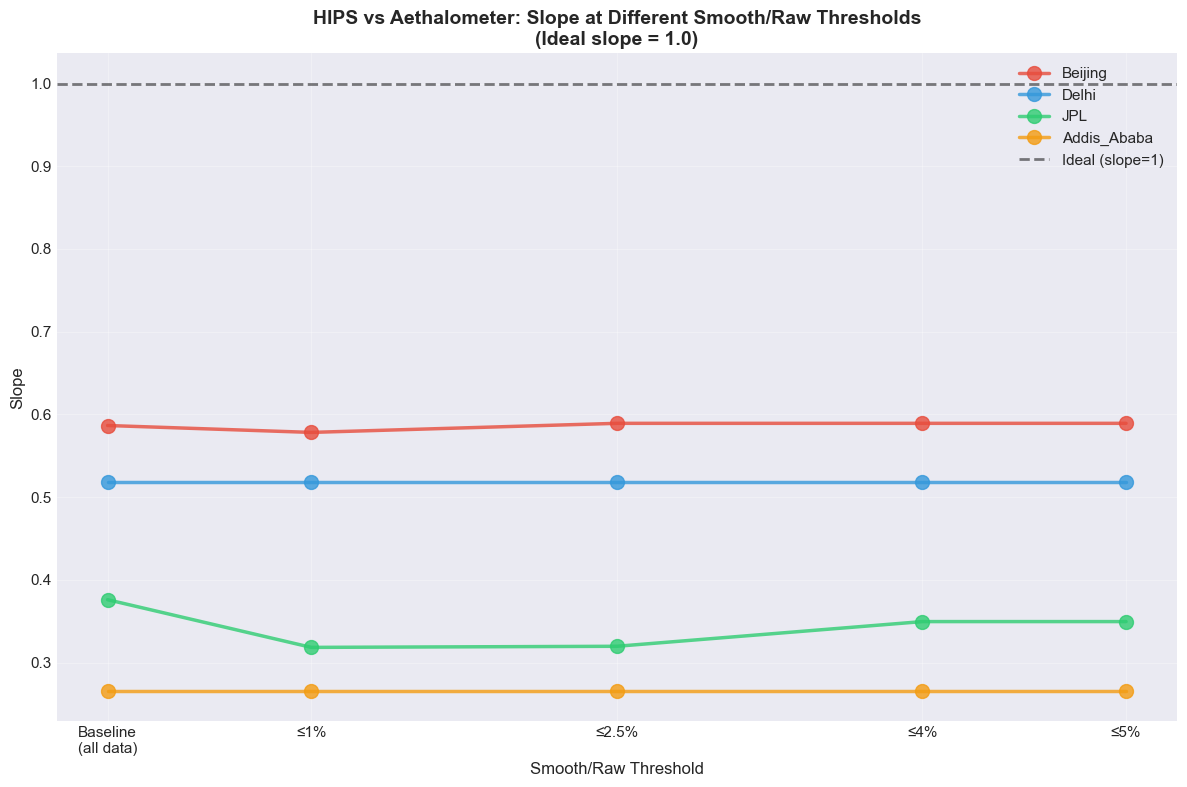

In [9]:
# Plot Slope vs Threshold for all sites
fig, ax = plt.subplots(figsize=(12, 8))

for site_name, results in threshold_results.items():
    config = SITES[site_name]
    
    slope_values = []
    x_vals = []
    
    # Baseline
    if results['baseline']:
        slope_values.append(results['baseline']['slope'])
        x_vals.append(0)
    
    # Each threshold
    for threshold in SMOOTH_RAW_THRESHOLDS:
        stats = results.get(threshold)
        if stats:
            slope_values.append(stats['slope'])
            x_vals.append(threshold)
    
    if len(slope_values) > 0:
        ax.plot(x_vals, slope_values, 'o-', color=config['color'], linewidth=2.5,
                markersize=10, label=site_name, alpha=0.8)

# Add ideal slope = 1 line
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Ideal (slope=1)')

ax.set_xticks(x_positions)
ax.set_xticklabels(['Baseline\n(all data)'] + [f'≤{t}%' for t in SMOOTH_RAW_THRESHOLDS])

ax.set_xlabel('Smooth/Raw Threshold', fontsize=12)
ax.set_ylabel('Slope', fontsize=12)
ax.set_title('HIPS vs Aethalometer: Slope at Different Smooth/Raw Thresholds\n(Ideal slope = 1.0)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Comprehensive Summary Table

In [10]:
# Comprehensive summary table
print("="*100)
print("COMPREHENSIVE SUMMARY: HIPS vs Aethalometer Smooth/Raw Threshold Analysis")
print("="*100)
print("\nComparing absorption-based methods (HIPS and Aethalometer)")
print("to isolate the effect of aethalometer smoothing algorithm.")

for site_name, results in threshold_results.items():
    print(f"\n{'-'*80}")
    print(f"{site_name}")
    print(f"{'-'*80}")
    
    baseline = results['baseline']
    
    print(f"\n{'Threshold':<15s} {'n':>6s} {'% Kept':>10s} {'R²':>10s} {'Slope':>10s} {'ΔR²':>10s} {'Δ|Slope-1|':>12s}")
    print("-" * 75)
    
    # Baseline
    if baseline:
        baseline_n = baseline['n']
        print(f"{'Baseline':<15s} {baseline['n']:>6d} {'100.0':>10s} {baseline['r_squared']:>10.3f} "
              f"{baseline['slope']:>10.3f} {'--':>10s} {'--':>12s}")
    
    # Each threshold
    for threshold in SMOOTH_RAW_THRESHOLDS:
        stats = results.get(threshold)
        if stats and baseline:
            pct_kept = (stats['n'] / baseline_n) * 100
            r2_change = stats['r_squared'] - baseline['r_squared']
            slope_improve = abs(baseline['slope'] - 1) - abs(stats['slope'] - 1)
            
            print(f"≤{threshold}%{'':>{13-len(str(threshold))}} {stats['n']:>6d} {pct_kept:>10.1f} "
                  f"{stats['r_squared']:>10.3f} {stats['slope']:>10.3f} {r2_change:>+10.3f} {slope_improve:>+12.3f}")
        else:
            print(f"≤{threshold}%{'':>{13-len(str(threshold))}} {'--':>6s} {'--':>10s} "
                  f"{'--':>10s} {'--':>10s} {'--':>10s} {'--':>12s}")
    
    # Recommendation
    if baseline:
        best_r2 = baseline['r_squared']
        best_threshold = 'Baseline'
        for threshold in SMOOTH_RAW_THRESHOLDS:
            stats = results.get(threshold)
            if stats and stats['r_squared'] > best_r2:
                best_r2 = stats['r_squared']
                best_threshold = f'≤{threshold}%'
        
        if best_threshold == 'Baseline':
            print(f"\n  ➤ Recommendation: No filtering needed (baseline R² = {baseline['r_squared']:.3f})")
        else:
            improvement = best_r2 - baseline['r_squared']
            print(f"\n  ➤ Recommendation: Use {best_threshold} threshold (R² improves by {improvement:+.3f})")

COMPREHENSIVE SUMMARY: HIPS vs Aethalometer Smooth/Raw Threshold Analysis

Comparing absorption-based methods (HIPS and Aethalometer)
to isolate the effect of aethalometer smoothing algorithm.

--------------------------------------------------------------------------------
Beijing
--------------------------------------------------------------------------------

Threshold            n     % Kept         R²      Slope        ΔR²   Δ|Slope-1|
---------------------------------------------------------------------------
Baseline            73      100.0      0.404      0.587         --           --
≤1%                 71       97.3      0.395      0.578     -0.009       -0.008
≤2.5%               72       98.6      0.408      0.589     +0.004       +0.003
≤4%                 72       98.6      0.408      0.589     +0.004       +0.003
≤5%                 72       98.6      0.408      0.589     +0.004       +0.003

  ➤ Recommendation: Use ≤2.5% threshold (R² improves by +0.004)

-------------

## 9. Comparison: HIPS vs FTIR EC Threshold Analysis

Let's also run the same analysis for FTIR EC vs Aethalometer to compare the two approaches.

In [11]:
# Match FTIR EC with aethalometer smooth/raw info for comparison
from data_matching import match_with_smooth_raw_info

ftir_aeth_data = {}

print("Matching FTIR EC with Aethalometer for comparison...")
print("="*70)

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_with_smooth_raw_info(
        site_name, df_aeth, filter_data, config['code']
    )
    
    if matched is not None and len(matched) >= 3:
        ftir_aeth_data[site_name] = matched
        print(f"{site_name}: {len(matched)} matched FTIR-Aeth pairs")

Matching FTIR EC with Aethalometer for comparison...
Beijing: 65 matched FTIR-Aeth pairs
Delhi: 24 matched FTIR-Aeth pairs
JPL: 42 matched FTIR-Aeth pairs
Addis_Ababa: 181 matched FTIR-Aeth pairs


In [12]:
# Compare HIPS vs FTIR EC threshold results side by side
print("="*100)
print("COMPARISON: HIPS vs FTIR EC Threshold Analysis Results")
print("="*100)
print("\nHIPS vs Aeth = Absorption vs Absorption (like-to-like)")
print("FTIR EC vs Aeth = Thermal vs Absorption (different techniques)")

# Calculate FTIR EC results
ftir_threshold_results = {}

for site_name, matched_df in ftir_aeth_data.items():
    site_results = {}
    
    # Baseline
    x_all = matched_df['aeth_bc'].dropna().values
    y_all = matched_df['filter_ec'].dropna().values
    valid_mask = (~np.isnan(matched_df['aeth_bc'].values)) & (~np.isnan(matched_df['filter_ec'].values))
    x_valid = matched_df['aeth_bc'].values[valid_mask]
    y_valid = matched_df['filter_ec'].values[valid_mask]
    
    if len(x_valid) >= 3:
        site_results['baseline'] = calculate_regression_stats(x_valid, y_valid)
    
    # Thresholds
    for threshold in SMOOTH_RAW_THRESHOLDS:
        below = matched_df[matched_df['smooth_raw_abs_pct'] <= threshold]
        x_below = below['aeth_bc'].dropna().values
        y_below = below['filter_ec'].dropna().values
        if len(x_below) >= 3:
            site_results[threshold] = calculate_regression_stats(x_below, y_below)
    
    ftir_threshold_results[site_name] = site_results

# Print comparison table
for site_name in hips_aeth_data.keys():
    print(f"\n{'-'*100}")
    print(f"{site_name}")
    print(f"{'-'*100}")
    
    hips_results = threshold_results.get(site_name, {})
    ftir_results = ftir_threshold_results.get(site_name, {})
    
    print(f"\n{'Threshold':<15s} {'HIPS R²':>10s} {'HIPS Slope':>12s} {'FTIR R²':>10s} {'FTIR Slope':>12s} {'R² Diff':>10s}")
    print("-" * 75)
    
    # Baseline
    hips_base = hips_results.get('baseline')
    ftir_base = ftir_results.get('baseline')
    
    if hips_base and ftir_base:
        r2_diff = hips_base['r_squared'] - ftir_base['r_squared']
        print(f"{'Baseline':<15s} {hips_base['r_squared']:>10.3f} {hips_base['slope']:>12.3f} "
              f"{ftir_base['r_squared']:>10.3f} {ftir_base['slope']:>12.3f} {r2_diff:>+10.3f}")
    
    # Thresholds
    for threshold in SMOOTH_RAW_THRESHOLDS:
        hips_stats = hips_results.get(threshold)
        ftir_stats = ftir_results.get(threshold)
        
        if hips_stats and ftir_stats:
            r2_diff = hips_stats['r_squared'] - ftir_stats['r_squared']
            print(f"≤{threshold}%{'':>{13-len(str(threshold))}} {hips_stats['r_squared']:>10.3f} "
                  f"{hips_stats['slope']:>12.3f} {ftir_stats['r_squared']:>10.3f} "
                  f"{ftir_stats['slope']:>12.3f} {r2_diff:>+10.3f}")
        elif hips_stats:
            print(f"≤{threshold}%{'':>{13-len(str(threshold))}} {hips_stats['r_squared']:>10.3f} "
                  f"{hips_stats['slope']:>12.3f} {'--':>10s} {'--':>12s} {'--':>10s}")
        elif ftir_stats:
            print(f"≤{threshold}%{'':>{13-len(str(threshold))}} {'--':>10s} {'--':>12s} "
                  f"{ftir_stats['r_squared']:>10.3f} {ftir_stats['slope']:>12.3f} {'--':>10s}")

COMPARISON: HIPS vs FTIR EC Threshold Analysis Results

HIPS vs Aeth = Absorption vs Absorption (like-to-like)
FTIR EC vs Aeth = Thermal vs Absorption (different techniques)

----------------------------------------------------------------------------------------------------
Beijing
----------------------------------------------------------------------------------------------------

Threshold          HIPS R²   HIPS Slope    FTIR R²   FTIR Slope    R² Diff
---------------------------------------------------------------------------
Baseline             0.404        0.587      0.197        0.556     +0.207
≤1%                  0.395        0.578      0.204        0.561     +0.191
≤2.5%                0.408        0.589      0.204        0.561     +0.204
≤4%                  0.408        0.589      0.204        0.561     +0.204
≤5%                  0.408        0.589      0.204        0.561     +0.204

---------------------------------------------------------------------------------------

## 10. Key Findings & Conclusions

In [13]:
# Key findings summary
print("="*100)
print("KEY FINDINGS: HIPS vs Aethalometer Smooth/Raw Threshold Analysis")
print("="*100)

print("""
METHODOLOGY:
- Compared HIPS (optical absorption) vs Aethalometer (optical absorption)
- Both measure light absorption → "like-to-like" comparison
- Tested filtering by smooth/raw BC difference thresholds (1%, 2.5%, 4%, 5%)

WHY THIS MATTERS:
- FTIR EC vs Aethalometer compares thermal vs optical (different physics)
- HIPS vs Aethalometer isolates aethalometer data quality issues
- Helps determine if smoothing algorithm causes systematic errors

INTERPRETATION GUIDE:
- R² improvement with filtering → smoothing may mask real variability
- Slope closer to 1.0 → better agreement between methods
- Consistent results across sites → robust finding
- Site-specific effects → local factors (dust, source mix) matter
""")

# Site-specific findings
print("\nSITE-SPECIFIC OBSERVATIONS:")
print("-" * 80)

for site_name, results in threshold_results.items():
    baseline = results.get('baseline')
    if not baseline:
        continue
    
    print(f"\n{site_name}:")
    print(f"  Baseline R² = {baseline['r_squared']:.3f}, Slope = {baseline['slope']:.3f}")
    
    # Find best threshold
    best_r2 = baseline['r_squared']
    best_threshold = None
    for threshold in SMOOTH_RAW_THRESHOLDS:
        stats = results.get(threshold)
        if stats and stats['r_squared'] > best_r2 + 0.01:  # Require meaningful improvement
            best_r2 = stats['r_squared']
            best_threshold = threshold
    
    if best_threshold:
        improvement = best_r2 - baseline['r_squared']
        print(f"  Best threshold: ≤{best_threshold}% (R² = {best_r2:.3f}, +{improvement:.3f})")
        print(f"  → Filtering IMPROVES correlation - smoothing may be affecting data")
    else:
        print(f"  No threshold significantly improves R²")
        if baseline['r_squared'] > 0.6:
            print(f"  → Good baseline correlation - smoothing not problematic")
        else:
            print(f"  → Poor baseline correlation - other factors dominate")

KEY FINDINGS: HIPS vs Aethalometer Smooth/Raw Threshold Analysis

METHODOLOGY:
- Compared HIPS (optical absorption) vs Aethalometer (optical absorption)
- Both measure light absorption → "like-to-like" comparison
- Tested filtering by smooth/raw BC difference thresholds (1%, 2.5%, 4%, 5%)

WHY THIS MATTERS:
- FTIR EC vs Aethalometer compares thermal vs optical (different physics)
- HIPS vs Aethalometer isolates aethalometer data quality issues
- Helps determine if smoothing algorithm causes systematic errors

INTERPRETATION GUIDE:
- R² improvement with filtering → smoothing may mask real variability
- Slope closer to 1.0 → better agreement between methods
- Consistent results across sites → robust finding
- Site-specific effects → local factors (dust, source mix) matter


SITE-SPECIFIC OBSERVATIONS:
--------------------------------------------------------------------------------

Beijing:
  Baseline R² = 0.404, Slope = 0.587
  No threshold significantly improves R²
  → Poor baseline co

---

## Notes

### Why HIPS vs Aethalometer is a Better Test

1. **Same measurement principle**: Both measure light absorption by particles
2. **Removes confounding factors**: No thermal vs optical comparison issues
3. **Cleaner interpretation**: If correlation improves with filtering, it's due to smoothing effects

### Interpreting Results

- **R² increases with stricter thresholds**: Smoothing algorithm may be masking real variability
- **Slope closer to 1.0**: Better physical agreement between methods
- **No improvement with filtering**: Either smoothing is appropriate, or other factors dominate

### Caveats

- HIPS uses filter samples (24-hour integrated), aethalometer is continuous
- MAC value affects HIPS conversion to BC equivalent
- Sampling timing differences may introduce scatter

---